In [153]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,Adagrad
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import tensorflow

In [6]:
# Paths of folders containing train and test data
TRAIN_FOLDER_PATH = "/Users/kalyanijaware/Documents/ML Project/features_train"
TEST_FOLDER_PATH = "/Users/kalyanijaware/Documents/ML Project/features_test"

In [7]:
# Names of features based on GeMAPS feature set
meta_data = pd.read_csv('feature_description.csv', encoding='ISO-8859-1', header=None)
col_names = list(meta_data[0])

In [8]:
df_dict = {'Participant_ID': [], 'features': []}  # Dict to store values
max_rows = 0  # Max number of rows present in the data (used for padding)

for file in os.listdir(TRAIN_FOLDER_PATH):
    
    file_name_split = file.split('.')
    file_type = file_name_split[1]
    file_name = file_name_split[0]

    if file_type == 'csv':
        # Fetch participant ID
        id = int(file_name.split('_')[1])
        df_dict['Participant_ID'].append(id)

        # Fetch data
        temp_df = pd.read_csv(TRAIN_FOLDER_PATH + '/' + file, names=col_names)

        # Remove null values
        if temp_df.isna().sum().values[0]>0:
            print(f"Removing null values present in {file}")
            temp_df = temp_df.dropna(axis=0)
        
        # Filter out rows where more than half of the feature values are zero
        zero_percentages = (temp_df == 0).mean(axis=1)  # Calculate the percentage of zero values in each row
        threshold = 0.5  # More than half
        temp_df = temp_df[zero_percentages <= threshold]
        
        # Add the features to dict
        df_dict['features'].append(temp_df)
        
        # Update max rows
        if temp_df.shape[0]>max_rows:
            max_rows = temp_df.shape[0] 

Removing null values present in spk_402.csv


In [6]:
max_rows

378

In [9]:
# Pad zeroes
for i in range(len(df_dict['features'])):
    df_dict['features'][i] = df_dict['features'][i].reindex(np.arange(max_rows), fill_value=0).values

In [10]:
# Convert the dict into dataframe
df_features = pd.DataFrame(df_dict)

In [11]:
# Read labels dict
df_labels = pd.read_csv('labels.csv', skipfooter=1, engine='python')
df_labels['Participant_ID'] = df_labels['Participant_ID'].astype(int)
df_labels.head()

,Participant_ID,Depression,Gender
0,303,0,0
1,304,0,0
2,305,0,1
3,310,0,1
4,312,0,1


In [12]:
merged_df = pd.merge(df_features, df_labels, on='Participant_ID')

In [13]:
merged_df.head()

,Participant_ID,features,Depression,Gender
0,448,"[[33.88331, 0.18847024, 31.197649, 31.198807, ...",1,1
1,475,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
2,313,"[[22.360157, 0.071260795, 20.776451, 22.337982...",0,1
3,449,"[[31.251434, 0.008560931, 31.196766, 31.198511...",0,0
4,339,"[[19.374094, 0.07061678, 18.158512, 18.906977,...",1,1


In [14]:
# Extract Features and Labels for tensorflow
features = merged_df['features'].to_list()
depression_labels = merged_df['Depression'].values
gender_labels = merged_df['Gender'].values

In [15]:
# Convert features to tensor object
features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
features = np.array(features_tensor).reshape(87, 378, 88, 1)

# Convert labels to proper shape
depression_labels = np.asarray(depression_labels).astype('float32').reshape((-1,1))
gender_labels = np.asarray(gender_labels).astype('float32').reshape((-1,1))

In [16]:
features.shape

(87, 378, 88, 1)

In [167]:
# define and train CNN Model
utils.set_random_seed(10)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), padding = "same",strides = (1,1), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                           input_shape=(378, 88, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (2, 2),  padding = "same",strides = (1,1),activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(4, (2, 2), activation='relu', padding = "same",strides = (1,1),
    #                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
   
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(features_tensor, depression_labels, epochs=50, batch_size=32, validation_split=0.15)

Epoch 1/50
3/3 [==============================] - 1s 110ms/step - loss: 319.4914 - accuracy: 0.4521 - val_loss: 57.7376 - val_accuracy: 0.8571
Epoch 2/50
3/3 [==============================] - 0s 70ms/step - loss: 130.4610 - accuracy: 0.6986 - val_loss: 112.8914 - val_accuracy: 0.1429
Epoch 3/50
3/3 [==============================] - 0s 68ms/step - loss: 92.0167 - accuracy: 0.3151 - val_loss: 22.4917 - val_accuracy: 0.2143
Epoch 4/50
3/3 [==============================] - 0s 68ms/step - loss: 16.5687 - accuracy: 0.7397 - val_loss: 16.5709 - val_accuracy: 0.8571
Epoch 5/50
3/3 [==============================] - 0s 73ms/step - loss: 36.5871 - accuracy: 0.6986 - val_loss: 14.9555 - val_accuracy: 0.8571
Epoch 6/50
3/3 [==============================] - 0s 72ms/step - loss: 18.9453 - accuracy: 0.7260 - val_loss: 7.8900 - val_accuracy: 0.8571
Epoch 7/50
3/3 [==============================] - 0s 67ms/step - loss: 2.7823 - accuracy: 0.8767 - val_loss: 9.7308 - val_accuracy: 0.3571
Epoch 8/50
3

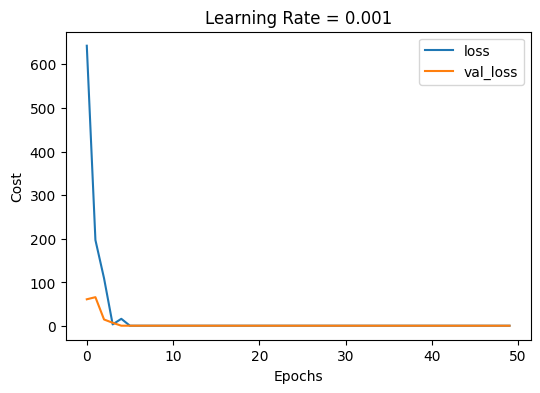

In [138]:
# plot the model
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [108]:
# define and train CNN Model
utils.set_random_seed(3)
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), padding = "same",use_bias = True,strides = (1,1), activation='relu',
                           input_shape=(378, 88, 1)),
    
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (2, 2),  padding = "same",use_bias = True,strides = (1,1),activation='relu'),
  
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    
    # tf.keras.layers.Conv2D(4, (2, 2), activation='relu', padding = "same",strides = (1,1),
    #                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(features_tensor, depression_labels, epochs=50, batch_size=16, validation_split=0.15)

Epoch 1/50
5/5 [==============================] - 1s 96ms/step - loss: 39.5273 - accuracy: 0.5616 - val_loss: 36.0873 - val_accuracy: 0.8571
Epoch 2/50
5/5 [==============================] - 0s 69ms/step - loss: 69.6699 - accuracy: 0.7123 - val_loss: 21.1629 - val_accuracy: 0.2857
Epoch 3/50
5/5 [==============================] - 0s 68ms/step - loss: 52.0888 - accuracy: 0.4247 - val_loss: 4.8748 - val_accuracy: 0.7857
Epoch 4/50
5/5 [==============================] - 0s 73ms/step - loss: 18.2459 - accuracy: 0.6575 - val_loss: 10.9750 - val_accuracy: 0.8571
Epoch 5/50
5/5 [==============================] - 0s 71ms/step - loss: 15.0818 - accuracy: 0.7397 - val_loss: 11.4148 - val_accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 0s 84ms/step - loss: 10.0316 - accuracy: 0.6986 - val_loss: 3.8906 - val_accuracy: 0.7857
Epoch 7/50
5/5 [==============================] - 0s 71ms/step - loss: 8.4943 - accuracy: 0.6712 - val_loss: 6.0255 - val_accuracy: 0.3571
Epoch 8/50
5/5 [=

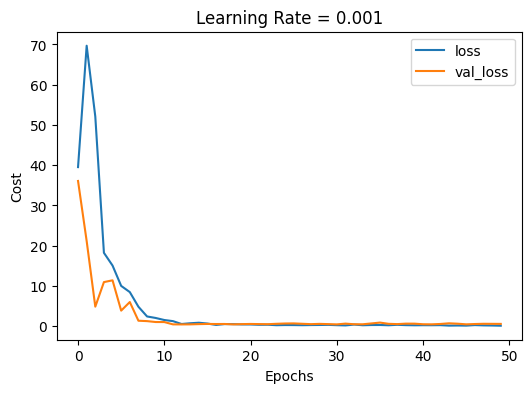

In [109]:
# plot the model
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history2.history["loss"], label="loss")
plt.plot(history2.history["val_loss"], label="val_loss")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()

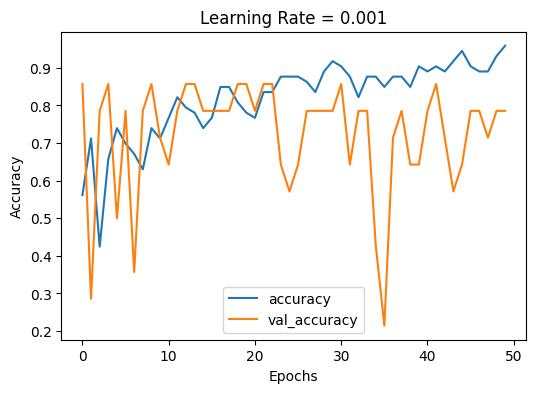

In [110]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history2.history["accuracy"], label="accuracy")
plt.plot(history2.history["val_accuracy"], label="val_accuracy")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Test Data

In [173]:
test_df_dict = {'Participant_ID': [], 'features': []}  # Dict to store values
max_rows = max_rows  # Max number of rows present in the training data (used for padding)

for file in os.listdir(TEST_FOLDER_PATH):
    
    file_name_split = file.split('.')
    file_type = file_name_split[1]
    file_name = file_name_split[0]

    if file_type == 'csv':
        # Fetch participant ID
        id = int(file_name.split('_')[1])
        test_df_dict['Participant_ID'].append(id)

        # Fetch data
        temp_df = pd.read_csv(TEST_FOLDER_PATH + '/' + file, names=col_names)

        # Remove null values
        if temp_df.isna().sum().values[0]>0:
            print(f"Removing null values present in {file}")
            temp_df = temp_df.dropna(axis=0)
        
        # Filter out rows where more than half of the feature values are zero
        zero_percentages = (temp_df == 0).mean(axis=1)  # Calculate the percentage of zero values in each row
        threshold = 0.5  # More than half
        temp_df = temp_df[zero_percentages <= threshold]
        
        # Add the features to dict
        test_df_dict['features'].append(temp_df)

In [174]:
# Pad zeroes
for i in range(len(test_df_dict['features'])):
    test_df_dict['features'][i] = test_df_dict['features'][i].reindex(np.arange(max_rows), fill_value=0).values

In [175]:
# Convert the dict into dataframe
test_features = pd.DataFrame(test_df_dict)

In [176]:
test_merged_df = pd.merge(test_features, df_labels, on='Participant_ID')
test_merged_df.head()

,Participant_ID,features,Depression,Gender
0,474,"[[31.240383, 0.007704522, 31.195211, 31.19749,...",0,1
1,312,"[[59.940285, 0.025738925, 58.02941, 60.76215, ...",0,1
2,305,"[[32.160255, 0.20058103, 23.145561, 35.63253, ...",0,1
3,315,"[[13.185594, 0.018975748, 12.951183, 13.3119, ...",0,1
4,415,"[[34.831165, 0.25052992, 31.193499, 31.198702,...",0,0


In [177]:
# Extract Features and Labels for tensorflow
test_features = test_merged_df['features'].to_list()
test_depression_labels = test_merged_df['Depression'].values
test_gender_labels = test_merged_df['Gender'].values

In [178]:
# Convert features to tensor object
test_features_tensor = tf.convert_to_tensor(test_features, dtype=tf.float32)
test_features = np.array(test_features_tensor).reshape(20, 378, 88, 1)

# Convert labels to proper shape
test_depression_labels = np.asarray(test_depression_labels).astype('float32').reshape((-1,1))
test_gender_labels = np.asarray(test_gender_labels).astype('float32').reshape((-1,1))

In [179]:
test_features.shape

(20, 378, 88, 1)

In [180]:

test_loss, test_acc = model.evaluate(test_features,  test_depression_labels)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

1/1 [==============================] - 0s 111ms/step - loss: 8.1222 - accuracy: 0.7000
Test loss:  8.122215270996094
Test accuracy:  0.699999988079071


In [181]:
test_loss_2, test_acc_2 = model2.evaluate(test_features,  test_depression_labels)
print("Test loss: ", test_loss_2)
print("Test accuracy: ", test_acc_2)

1/1 [==============================] - 0s 62ms/step - loss: 1.1804 - accuracy: 0.6000
Test loss:  1.180363655090332
Test accuracy:  0.6000000238418579


1/1 [==============================] - 0s 45ms/step
Confusion Matrix 
 [[11  3]
 [ 3  3]]


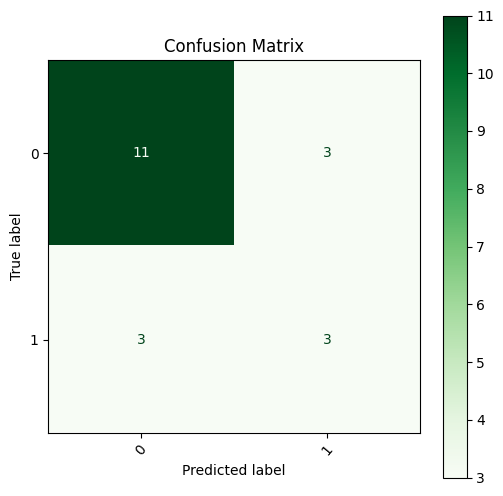

In [182]:
#Making predictions for the test set with the CNN model from b)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
y_pred = model.predict(test_features)
y_pred_classes = np.where(y_pred>0.5,1,0)

conf_matrix = confusion_matrix(test_depression_labels, y_pred_classes)
print("Confusion Matrix \n", conf_matrix)

#Visualizing the confusion matrix
plt.rcParams['figure.figsize'] = (6, 6)
display_c_m = ConfusionMatrixDisplay(conf_matrix)
display_c_m.plot(cmap='Greens', xticks_rotation=50)
plt.title('Confusion Matrix')
plt.show()

In [183]:
balanced_accuracy_score(test_depression_labels, y_pred_classes)

0.6428571428571428